# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Data

In [3]:
data = pd.read_csv('InshortsScraped.csv')

In [4]:
data.shape

(5373, 8)

In [5]:
data.head()

,news,national,sports,world,politics,technology,entertainment,hatke
0,7 IITs among India's top higher education inst...,1,0,0,0,0,0,0
1,They forget she's 14: Devgn on trolls criticis...,0,0,0,0,0,1,0
2,Haven't earned so much that I can wear new clo...,0,0,0,0,0,1,0
3,Fans in US sing Desi Girl for Priyanka outside...,0,0,0,0,0,1,0
4,"Dhoni bhai was very angry, he hugged me after ...",0,1,0,0,0,0,0


In [6]:
data.describe()

,national,sports,world,politics,technology,entertainment,hatke
count,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000
mean,0.284571,0.169551,0.130281,0.247720,0.180905,0.127862,0.009864
std,0.451252,0.375273,0.336644,0.431729,0.384975,0.333967,0.098836
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Preprocesing

## Data Cleaning

In [7]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import langdetect

def spell_correct(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)    
    return text

def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)

remove_punc = lambda x : re.sub(r"\W", ' ', x)

remove_num = lambda x : re.sub(r"\d", ' ', x)

remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)

lower_case = lambda x : x.lower()

stop_words = set(nltk.corpus.stopwords.words('english'))
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)

ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())

wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())

def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos

def cleanText(x, rsw, stm, lem, tgps):
    x = str(x)
    x = remove_url(x)
    x = lower_case(x)
    x = spell_correct(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
    
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

In [8]:
data['news_c'] = data['news'].apply(lambda x : cleanText(x, True, True, False, False))

## Vectorizing

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data['news_c'])
vector = vectorizer.transform(data['news_c'])

In [11]:
Y = data.drop(['news', 'news_c'], axis = 1)

# Machine Learning

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(vector, Y, test_size=0.33, random_state=42)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [16]:
model_scores = pd.DataFrame()
model_accuracies = pd.DataFrame()
algo_dict = {
    'LR': LogisticRegression,
    'MNB': MultinomialNB,
    'DTC': DecisionTreeClassifier,
    'SGDC': SGDClassifier
}
@interact
def machinelearing(algo = ['LR', 'MNB', 'DTC', 'SGDC']):
    modelscores = []
    for col in ['national', 'sports', 'world', 'politics', 'technology', 'entertainment', 'hatke']:
        print(col)
        model = algo_dict[algo]()
        model.fit(X_train, Y_train[col])
        y_pred = model.predict(X_test)
        print(confusion_matrix(Y_test[col], y_pred))
        print(classification_report(Y_test[col], y_pred))
        modelscores.append((f1_score(Y_test[col], y_pred), accuracy_score(Y_test[col], y_pred)))
    model_scores[algo] = list(map(lambda x : x[0], modelscores))
    model_accuracies[algo] = list(map(lambda x : x[1], modelscores))

interactive(children=(Dropdown(description='algo', options=('LR', 'MNB', 'DTC', 'SGDC'), value='LR'), Output()…

## Performance Evaluation

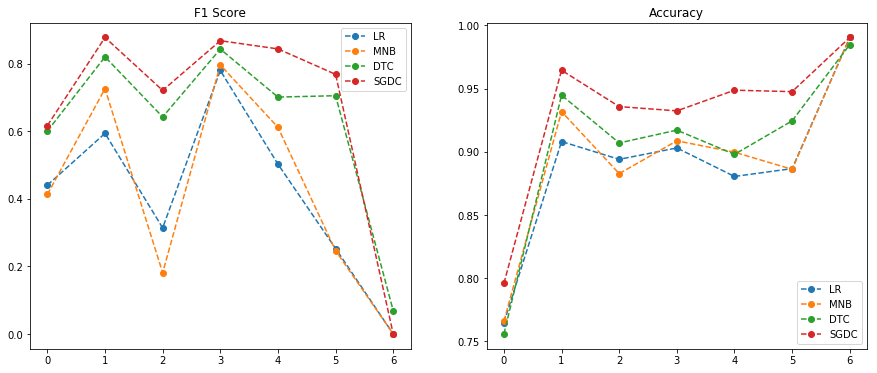

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
for x in model_scores:
    ax[0].plot(model_scores[x], '--o',label=x)
ax[0].title.set_text('F1 Score')
ax[0].legend()

for x in model_accuracies:
    ax[1].plot(model_accuracies[x], '--o',label=x)
ax[1].title.set_text('Accuracy')
ax[1].legend()

plt.show()